In [2]:
import cv2
import os
import sklearn
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4
sess = tf.compat.v1.Session(config=config)
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

IMAGE_SIZE = 128
BATCH_SIZE = 16
VERBOSE = 1

class_names = ["no", "yes"]
base_path = "../input/brain-tumor-detection"

x_train=[]
y_train=[]

for i in class_names:
    folderPath = os.path.join(base_path,i)
    for j in tqdm(os.listdir(folderPath), ncols=70):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Training dataset Loading complete.')

# Loading Testing Datasets from folders
#for i in class_names:
    #folderPath = os.path.join(os.path.join(base_path, 'Testing'), i)
    #for j in tqdm(os.listdir(folderPath), ncols=70):
        #img = cv2.imread(os.path.join(folderPath, j))
        #img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        #x_train.append(img)
        #y_train.append(i)

aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,horizontal_flip=True, fill_mode="nearest")

x_train = np.array(x_train)
y_train = np.array(y_train)
x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)

print('Testing dataset Loading complete.')

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=47, test_size=0.10)

y_train_new = [class_names.index(i) for i in y_train]
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)
y_test_new = [class_names.index(i) for i in y_test]
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

2022-11-13 12:26:14.512076: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 12:26:14.569994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 12:26:14.695240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 12:26:14.696165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


100%|████████████████████████████| 1500/1500 [00:12<00:00, 116.62it/s]


Training dataset Loading complete.
Testing dataset Loading complete.


In [11]:
inputShape = (IMAGE_SIZE, IMAGE_SIZE, 3)
xception = Xception(weights="../input/pretrained-model/xception_weights_tf_dim_ordering_tf_kernels_notop.h5", input_shape=inputShape, include_top=False)
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(2, activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs=model)

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("xception.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=VERBOSE)

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history=model.fit(aug.flow(x_train, y_train,batch_size=BATCH_SIZE),
          
validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BATCH_SIZE,
epochs=3, callbacks=[reduce_lr, checkpoint, tensorboard])
result = model.evaluate(x_test, y_test)
print(result)

2022-11-13 12:28:06.396480: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-11-13 12:28:06.396535: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-11-13 12:28:06.580158: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-11-13 12:28:06.580386: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/3
  1/168 [..............................] - ETA: 10:31 - loss: 0.7230 - accuracy: 0.5000

2022-11-13 12:28:10.861190: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-11-13 12:28:10.861241: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/168 [..............................] - ETA: 1:00 - loss: 0.7144 - accuracy: 0.5625 

2022-11-13 12:28:11.575483: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-13 12:28:11.578462: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-11-13 12:28:11.741467: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1147 callback api events and 1144 activity events. 
2022-11-13 12:28:11.786553: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-11-13 12:28:11.840063: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_11_13_12_28_11

2022-11-13 12:28:11.870514: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_11_13_12_28_11/be60be49c23a.trace.json.gz
2022-11-13 12:28:11.945216: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/pl

168/168 [==============================] - 20s 96ms/step - loss: 0.3326 - accuracy: 0.8715 - val_loss: 3.7271 - val_accuracy: 0.8733

Epoch 00001: val_accuracy improved from -inf to 0.87333, saving model to xception.h5
Epoch 2/3
168/168 [==============================] - 15s 87ms/step - loss: 0.1428 - accuracy: 0.9560 - val_loss: 0.8103 - val_accuracy: 0.7400

Epoch 00002: val_accuracy did not improve from 0.87333
Epoch 3/3
168/168 [==============================] - 14s 85ms/step - loss: 0.1030 - accuracy: 0.9687 - val_loss: 0.2442 - val_accuracy: 0.9433

Epoch 00003: val_accuracy improved from 0.87333 to 0.94333, saving model to xception.h5
10/10 [==============================] - 0s 26ms/step - loss: 0.2442 - accuracy: 0.9433
[0.24418550729751587, 0.9433333277702332]


In [13]:
from PIL import Image

In [16]:
img = cv2.imread('../input/brain-tumor-detection/pred/pred12.jpg')
img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
img1=np.array(img)
img1=img1.reshape(1,128,128,3)
img1.shape

(1, 128, 128, 3)

No tumor detected


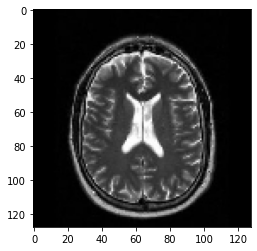

In [17]:
plt.imshow(img)
predictions=model.predict(img1)
predict=np.argmax(predictions[0])
if predict==1:
    print("Tumor Detected")
else:
    print("No tumor detected")

In [7]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

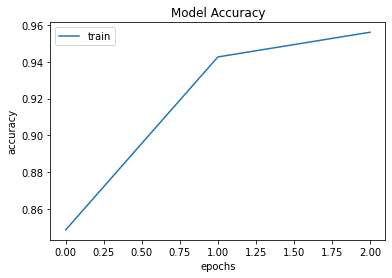

In [8]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train'],loc='upper left')
plt.show()

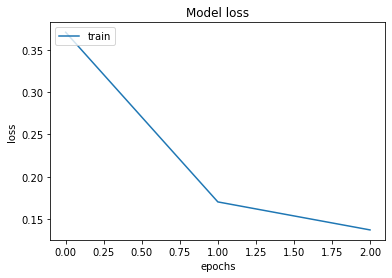

In [9]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'],loc='upper left')
plt.show()